In [ ]:
import pandas as pd
import numpy as np
audata = pd.read_csv("RESULT_new3/zn/zn2106_zn2107_final.csv", index_col=[0], parse_dates=[0])
audata.index = audata.index + pd.Timedelta(hours=5)
audata

In [94]:
data_all = audata

pd_date_list = pd.DataFrame()
pd_date_list['time_stamp'] = pd.to_datetime(data_all['trading_date'])
# normalize, count values, convert to dataframe
pd_date_list = pd_date_list['time_stamp'].dt.normalize().value_counts().to_frame().reset_index()
# rename columns
pd_date_list.columns = ['time_stamp', 'count']
pd_date_list.sort_values(by='time_stamp',inplace=True)
pd_date_list = pd_date_list.reset_index()
pd_date_list.drop(columns='index',inplace=True)
pd_date_list


,time_stamp,count
0,2021-04-01,2798
1,2021-04-02,3032
2,2021-04-06,1648
3,2021-04-07,2677
4,2021-04-08,2991
5,2021-04-09,3174
6,2021-04-12,2996
7,2021-04-13,3001
8,2021-04-14,2630
9,2021-04-15,2951


In [92]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 1
K = 0
beta = 0
data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    model = sm.OLS(data.last_A, data.last_B).fit()
    

    beta = model.params['last_B']


    eps = data.last_A - data.last_B * beta
    eps2 = test_data.last_A - test_data.last_B * beta
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta

    Spread = data.last_A - data.last_B
    Spread2 = test_data.last_A - test_data.last_B
    Spread2_ask = test_data.bid_A - test_data.ask_B
    Spread2_bid = test_data.ask_A - test_data.bid_B

    print(" ")
    print('test_day:',start_time)
    print(model.params)
    # best_k = find_best_k(eps,Spread)

    #进入交易
    # if K == 0:
    #     K = best_k

    # K = best_k * 0.4 + K * 0.6
    K = 1.06
    up_threshold =  K * np.std(eps)
    # up_threshold = 10
    down_threshold = - up_threshold

    # temp = np.std(eps) * 5
    # up_threshold_stop = temp * 0.4 + up_threshold_stop *0.6
    up_threshold_stop = np.std(eps) * 15
    biggest_lost = -80
    # if up_threshold_stop < 60:
    #     up_threshold_stop = 60
    # if up_threshold_stop > 200:
    #     up_threshold_stop = 200
    down_threshold_stop = -up_threshold_stop


    print('beta:',beta)
    print('阈值：',up_threshold)
    print('止损点：',up_threshold_stop)

    for i, v in enumerate(eps2.values):
        #交易时间点判断:去除开盘前10分钟和收盘前十分钟
        start_time1 = datetime.time(2,10,0)
        start_time2 = datetime.time(14,10,0)

        end_time1 = datetime.time(5,50,0)
        end_time2 = datetime.time(19,50,0)
        
        if (eps2_ask.index[i].time() > start_time1 and eps2_ask.index[i].time() < end_time1) or \
            (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

            ask_price = eps2_ask[i]
            bid_price = eps2_bid[i]
            if not holding:
                # 判断进场条件
                if ask_price > up_threshold and stop_event != 'up_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'b-a'
                    print(len(enter_record),Spread2_ask.index[i],'b-a进场', Spread2_ask[i], ask_price)
                    enter_record.append((Spread2_ask[i], ask_price))
                elif bid_price < down_threshold and stop_event != 'down_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'a-b'
                    print(len(enter_record),Spread2_bid.index[i],'a-b进场', Spread2_bid[i], bid_price)
                    enter_record.append((Spread2_bid[i], bid_price))
                    
            elif holding:
                # 判断离场条件
                if direction == 'a-b' and ask_price > down_threshold:
                    holding = False
                    print(Spread2_ask.index[i],'a-b出场', Spread2_ask[i], ask_price)
                    out_record.append((Spread2_ask[i], ask_price))
                    
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    single_cost = 1.2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price < up_threshold:
                    holding = False
                    print(Spread2_bid.index[i],'b-a出场', Spread2_bid[i], bid_price)
                    out_record.append((Spread2_bid[i], bid_price))
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    single_cost = 1.2          
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                #判断止损条件
                elif direction == 'a-b' and ask_price < down_threshold_stop:
                    holding = False
                    stop_event = 'down_stop'
                    print(Spread2_ask.index[i],'a-b止损出场', Spread2_ask[i], ask_price)
                    out_record.append((Spread2_ask[i], ask_price))
                    
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    single_cost = 1.2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price > up_threshold_stop:
                    holding = False
                    stop_event = 'up_stop'
                    print(Spread2_bid.index[i],'b-a止损出场', Spread2_bid[i], bid_price)
                    out_record.append((Spread2_bid[i], bid_price))
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    single_cost = 1.2         
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                else: #判断最大亏损有没有达到阈值
                    if direction == 'a-b':
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'down_stop'
                            print(Spread2_ask.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price)
                            out_record.append((Spread2_ask[i], ask_price))
                            single_cost = 1.2
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)
                    elif direction =='b-a':
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'up_stop'
                            print(Spread2_bid.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price)
                            out_record.append((Spread2_bid[i], bid_price))
                            single_cost = 1.2          
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

            
if holding:
    print('还有持仓，强平',Spread2_bid[i], bid_price)
    if direction == 'a-b':
        ret = (Spread2_ask[-1] - enter_record[-1][0])
    else:
        ret = (enter_record[-1][0] - Spread2_bid[-1])
    
    single_cost = 1.2 
    pure_pnl.append(ret)
    trading_cost.append(single_cost)
    pnl.append(ret - single_cost)


 
test_day: 2021-04-02 00:00:00
last_B    1.001885
dtype: float64
beta: 1.001885377961354
阈值： 4.967898242990741
止损点： 70.30044683477463
0 2021-04-02 02:10:25 a-b进场 35.0 -5.243392585100082
2021-04-02 02:20:51.500000 a-b出场 40.0 -0.29052703413253766
1 2021-04-02 02:43:39 a-b进场 35.0 -5.328234593358502
2021-04-02 03:03:16.500000 a-b出场 40.0 -0.31880770355201093
2 2021-04-02 03:27:42.500000 a-b进场 35.0 -5.262246364713064
2021-04-02 03:52:24.500000 a-b出场 40.0 -0.30938081374551984
3 2021-04-02 16:09:10 b-a进场 50.0 9.605777177992422
2021-04-02 19:19:14 b-a出场 45.0 4.737753635286936
 
test_day: 2021-04-06 00:00:00
last_B    1.001985
dtype: float64
beta: 1.0019854514864224
阈值： 6.1013121113158
止损点： 86.33932232994056
4 2021-04-06 14:10:04.500000 b-a进场 55.0 11.78664839801786
 
test_day: 2021-04-07 00:00:00
last_B    1.00269
dtype: float64
beta: 1.0026901220740077
阈值： 5.06956540113677
止损点： 71.73913303495428
2021-04-07 02:10:02 b-a出场 60.0 1.503295500704553
5 2021-04-07 03:44:43 a-b进场 50.0 -8.49670449929544

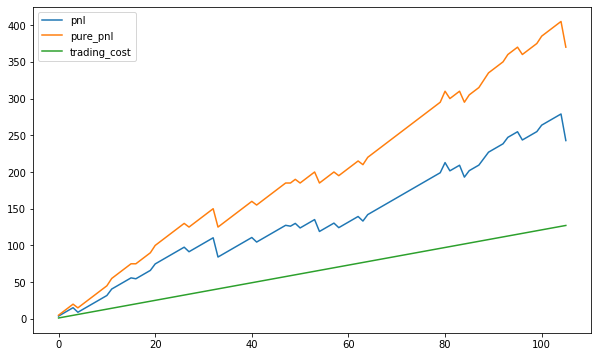

242.80000000000007

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [80]:
import statsmodels.api as sm
import datetime
K_options = np.arange(0.4, 1.5, 0.02)
res_test = []
for K in K_options:

    holding = False
    direction = None  # "a-b", "b-a"
    stop_event = "none"
    enter_record = []
    out_record = []

    pure_pnl = []
    trading_cost = []
    pnl = []
    cost_rate = 0.5 / 10000
    delta_days = 1
    beta = 0
    data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
    #取最近5天数据
    for date_index in range(0,len(pd_date_list) - delta_days):

        start_time = pd_date_list['time_stamp'].iloc[date_index]
        end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
        data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

        start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
        end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
        test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

        model = sm.OLS(data.last_A, data.last_B).fit()
        

        beta = model.params['last_B']


        eps = data.last_A - data.last_B * beta
        eps2 = test_data.last_A - test_data.last_B * beta
        eps2_ask = test_data.bid_A - test_data.ask_B * beta
        eps2_bid = test_data.ask_A - test_data.bid_B * beta

        Spread = data.last_A - data.last_B
        Spread2 = test_data.last_A - test_data.last_B
        Spread2_ask = test_data.bid_A - test_data.ask_B
        Spread2_bid = test_data.ask_A - test_data.bid_B

        print(" ")
        print('test_day:',start_time)
        print(model.params)
        # best_k = find_best_k(eps,Spread)

        #进入交易
        # if K == 0:
        #     K = best_k

        # K = best_k * 0.4 + K * 0.6
        # K = 0.5
        up_threshold =  K * np.std(eps)
        # up_threshold = 10
        down_threshold = - up_threshold

        # temp = np.std(eps) * 5
        # up_threshold_stop = temp * 0.4 + up_threshold_stop *0.6
        up_threshold_stop = np.std(eps) * 20
        biggest_lost = -100
        # if up_threshold_stop < 60:
        #     up_threshold_stop = 60
        # if up_threshold_stop > 200:
        #     up_threshold_stop = 200
        down_threshold_stop = -up_threshold_stop


        print('beta:',beta)
        print('阈值：',up_threshold)
        print('止损点：',up_threshold_stop)

        for i, v in enumerate(eps2.values):
            #交易时间点判断:去除开盘前10分钟和收盘前十分钟
            start_time1 = datetime.time(2,10,0)
            start_time2 = datetime.time(14,10,0)

            end_time1 = datetime.time(5,50,0)
            end_time2 = datetime.time(19,50,0)
            
            if (eps2_ask.index[i].time() > start_time1 and eps2_ask.index[i].time() < end_time1) or \
                (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

                ask_price = eps2_ask[i]
                bid_price = eps2_bid[i]
                if not holding:
                    # 判断进场条件
                    if ask_price > up_threshold and stop_event != 'up_stop':
                        holding = True
                        stop_event = "none"
                        direction = 'b-a'
                        print(len(enter_record),Spread2_ask.index[i],'b-a进场', Spread2_ask[i], ask_price)
                        enter_record.append((Spread2_ask[i], ask_price))
                    elif bid_price < down_threshold and stop_event != 'down_stop':
                        holding = True
                        stop_event = "none"
                        direction = 'a-b'
                        print(len(enter_record),Spread2_bid.index[i],'a-b进场', Spread2_bid[i], bid_price)
                        enter_record.append((Spread2_bid[i], bid_price))
                        
                elif holding:
                    # 判断离场条件
                    if direction == 'a-b' and ask_price > down_threshold:
                        holding = False
                        print(Spread2_ask.index[i],'a-b出场', Spread2_ask[i], ask_price)
                        out_record.append((Spread2_ask[i], ask_price))
                        
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        single_cost = 1.2

                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                        
                        
                    elif direction =='b-a' and bid_price < up_threshold:
                        holding = False
                        print(Spread2_bid.index[i],'b-a出场', Spread2_bid[i], bid_price)
                        out_record.append((Spread2_bid[i], bid_price))
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        single_cost = 1.2          
                        
                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)

                    #判断止损条件
                    elif direction == 'a-b' and ask_price < down_threshold_stop:
                        holding = False
                        stop_event = 'down_stop'
                        print(Spread2_ask.index[i],'a-b止损出场', Spread2_ask[i], ask_price)
                        out_record.append((Spread2_ask[i], ask_price))
                        
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        single_cost = 1.2

                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                        
                        
                    elif direction =='b-a' and bid_price > up_threshold_stop:
                        holding = False
                        stop_event = 'up_stop'
                        print(Spread2_bid.index[i],'b-a止损出场', Spread2_bid[i], bid_price)
                        out_record.append((Spread2_bid[i], bid_price))
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        single_cost = 1.2         
                        
                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                    else: #判断最大亏损有没有达到阈值
                        if direction == 'a-b':
                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if single_ret < biggest_lost:
                                holding = False
                                stop_event = 'down_stop'
                                print(Spread2_ask.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price)
                                out_record.append((Spread2_ask[i], ask_price))
                                single_cost = 1.2
                                pure_pnl.append(single_ret)
                                trading_cost.append(single_cost)
                                pnl.append(single_ret - single_cost)
                        elif direction =='b-a':
                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if single_ret < biggest_lost:
                                holding = False
                                stop_event = 'up_stop'
                                print(Spread2_bid.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price)
                                out_record.append((Spread2_bid[i], bid_price))
                                single_cost = 1.2          
                                
                                pure_pnl.append(single_ret)
                                trading_cost.append(single_cost)
                                pnl.append(single_ret - single_cost)

                
    if holding:
        print('还有持仓，强平',Spread2_bid[i], bid_price)
        if direction == 'a-b':
            ret = (Spread2_ask[-1] - enter_record[-1][0])
        else:
            ret = (enter_record[-1][0] - Spread2_bid[-1])
        
        single_cost = 1.2 
        pure_pnl.append(ret)
        trading_cost.append(single_cost)
        pnl.append(ret - single_cost)


    res_test.append([K,np.array(pnl).sum()])


ype: float64
beta: 1.0002656835394426
阈值： 7.069205602928509
止损点： 96.83843291682884
2021-04-30 02:10:03 a-b出场 5.0 -0.9114587525982643
38 2021-04-30 03:03:46 a-b进场 -5.0 -10.8423810323402
2021-04-30 03:05:47.500000 a-b出场 0.0 -5.803856919123064
39 2021-04-30 03:07:22 a-b进场 -5.0 -10.81979793149003
2021-04-30 03:10:17 a-b出场 0.0 -5.807842172212986
40 2021-04-30 03:19:41.500000 a-b进场 -5.0 -10.810499007609906
2021-04-30 03:35:22.500000 a-b出场 0.0 -5.810499007609906
41 2021-04-30 03:45:41.500000 a-b进场 -5.0 -10.818469513793389
2021-04-30 04:23:37.500000 a-b出场 0.0 -5.849023120827042
42 2021-04-30 05:04:03.500000 a-b进场 -5.0 -10.826440019976872
2021-04-30 05:09:52 a-b出场 0.0 -5.823783184579952
43 2021-04-30 14:30:02 a-b进场 -5.0 -10.810499007609906
2021-04-30 14:50:23.500000 a-b出场 0.0 -5.805185336819704
44 2021-04-30 15:00:00 a-b进场 -5.0 -10.803856919123064
 
test_day: 2021-05-06 00:00:00
last_B    0.999892
dtype: float64
beta: 0.9998916216907711
阈值： 7.488705801012555
止损点： 102.58501097277467
 
test_day: 

In [81]:
res_test

[[0.4, 155.00000000000006],
 [0.42000000000000004, 172.40000000000003],
 [0.44000000000000006, 177.60000000000008],
 [0.4600000000000001, 181.20000000000005],
 [0.4800000000000001, 182.39999999999998],
 [0.5000000000000001, 187.39999999999998],
 [0.5200000000000001, 188.80000000000007],
 [0.5400000000000001, 191.40000000000003],
 [0.5600000000000002, 199.20000000000005],
 [0.5800000000000002, 216.60000000000002],
 [0.6000000000000002, 215.40000000000003],
 [0.6200000000000002, 221.60000000000002],
 [0.6400000000000002, 223.0],
 [0.6600000000000003, 220.39999999999998],
 [0.6800000000000003, 226.60000000000002],
 [0.7000000000000003, 212.8],
 [0.7200000000000003, 211.8],
 [0.7400000000000003, 216.60000000000002],
 [0.7600000000000003, 211.40000000000003],
 [0.7800000000000004, 219.0],
 [0.8000000000000004, 225.2],
 [0.8200000000000004, 220.2],
 [0.8400000000000004, 208.80000000000007],
 [0.8600000000000004, 192.40000000000003],
 [0.8800000000000004, 207.60000000000008],
 [0.900000000000

In [ ]:
start_time = pd_date_list['time_stamp'].iloc[34]
end_time = pd_date_list['time_stamp'].iloc[34] + pd.Timedelta("1 day")
data = data_all[(data_all.index >= start_time) & (data_all.index <= end_time)]

model = sm.OLS(data.last_A, data.last_B).fit()
print(data)
print(model.params)

beta = model.params['last_B']

eps = data.last_A - data.last_B * beta

Spread = data.last_A - data.last_B
best_k = find_best_k(eps,Spread)

#进入交易

K_use = best_k * 0.4 + K * 0.6
up_threshold =  K_use * np.std(eps)
down_threshold = - up_threshold
print(K_use)

In [ ]:
up_threshold